## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 16 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 256 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.01]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    print(model.summary())
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=0.5, # 学习速率被降低的因数。新的学习速率 = 学习速率 * 因数
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5,  #没有进步的训练轮数，在这之后训练速率会被降低
                              verbose=1)   # 0：安静，1：更新信息 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

Train on 50000 samples, validate on 10000 samples
Epoch 1/16
50000/50000 [==============================] - 5s 102us/step - loss: 1.7220 - acc: 0.3890 - val_loss: 1.6763 - val_acc: 0.3955
Epoch 2/16
50000/50000 [==============================] - 4s 81us/step - loss: 1.5040 - acc: 0.4631 - val_loss: 1.5353 - val_acc: 0.4524
Epoch 3/16
50000/50000 [==============================] - 4s 85us/step - loss: 1.4116 - acc: 0.4993 - val_loss: 1.5429 - val_acc: 0.4538 1.4146 - a
Epoch 4/16
50000/50000 [==============================] - 4s 78us/step - loss: 1.3424 - acc: 0.5239 - val_loss: 1.5058 - val_acc: 0.4621
Epoch 5/16
50000/50000 [==============================] - 4s 82us/step - loss: 1.2865 - acc: 0.5419 - val_loss: 1.4993 - val_acc: 0.4701
Epoch 6/16
50000/50000 [==============================] - 4s 78us/step - loss: 1.2393 - acc: 0.5603 - val_loss: 1.5846 - val_acc: 0.4387
Epoch 7/16
50000/50000 [==============================] - 4s 79us/step - loss: 1.1930 - acc: 0.5773 - val_loss: 1.48

Epoch 5/16
50000/50000 [==============================] - 4s 73us/step - loss: 1.2576 - acc: 0.5540 - val_loss: 1.9641 - val_acc: 0.3577
Epoch 6/16
50000/50000 [==============================] - 4s 73us/step - loss: 1.2100 - acc: 0.5697 - val_loss: 1.7866 - val_acc: 0.4075
Epoch 7/16
50000/50000 [==============================] - 4s 72us/step - loss: 1.1615 - acc: 0.5879 - val_loss: 1.7013 - val_acc: 0.4230
Epoch 8/16
50000/50000 [==============================] - 4s 73us/step - loss: 1.1216 - acc: 0.5999 - val_loss: 2.5410 - val_acc: 0.2671
Epoch 9/16
50000/50000 [==============================] - 4s 73us/step - loss: 1.0873 - acc: 0.6119 - val_loss: 2.1626 - val_acc: 0.3360
Epoch 10/16
50000/50000 [==============================] - 4s 75us/step - loss: 1.0479 - acc: 0.6276 - val_loss: 1.8051 - val_acc: 0.4299
Epoch 11/16
50000/50000 [==============================] - 4s 73us/step - loss: 1.0135 - acc: 0.6395 - val_loss: 1.7867 - val_acc: 0.4295
Epoch 12/16
50000/50000 [==============

Epoch 10/16
50000/50000 [==============================] - 4s 81us/step - loss: 1.0431 - acc: 0.6311 - val_loss: 1.8826 - val_acc: 0.4089
Epoch 11/16
50000/50000 [==============================] - 4s 78us/step - loss: 1.0081 - acc: 0.6425 - val_loss: 1.7578 - val_acc: 0.4234
Epoch 12/16
50000/50000 [==============================] - 4s 76us/step - loss: 0.9725 - acc: 0.6563 - val_loss: 1.8188 - val_acc: 0.3995

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13/16
50000/50000 [==============================] - 4s 75us/step - loss: 0.8682 - acc: 0.6995 - val_loss: 1.4469 - val_acc: 0.5069
Epoch 14/16
50000/50000 [==============================] - 4s 77us/step - loss: 0.8286 - acc: 0.7131 - val_loss: 1.4737 - val_acc: 0.4998
Epoch 15/16
50000/50000 [==============================] - 4s 75us/step - loss: 0.7976 - acc: 0.7250 - val_loss: 1.5587 - val_acc: 0.4939
Epoch 16/16
50000/50000 [==============================] - 4s 76us/step - loss: 0.7725 - ac

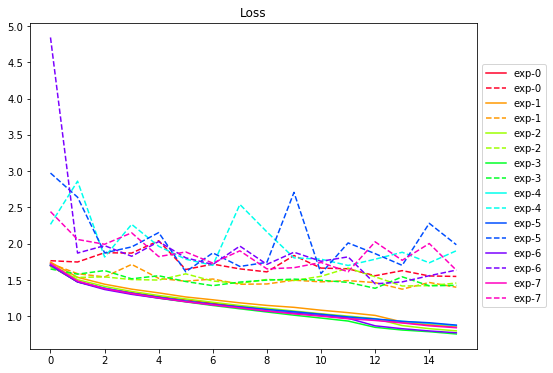

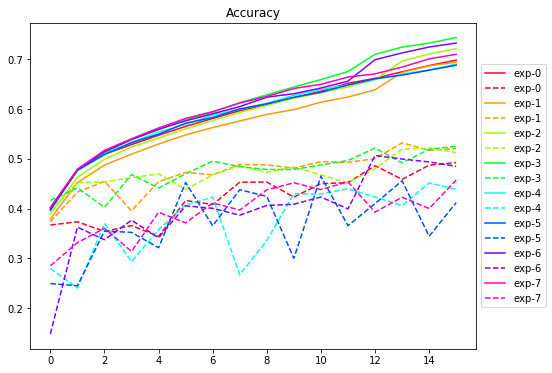

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()